<a href="https://colab.research.google.com/github/eswarpeddinti98/newproject/blob/main/02_ANN_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminaries

We download the data:

In [268]:
!wget https://gitlab.com/andras.simonyi/10_days_AI_training_data/raw/65de5908dccf120762b305238e02610a8c18a3f9/titanic_train.csv

--2024-11-20 09:14:30--  https://gitlab.com/andras.simonyi/10_days_AI_training_data/raw/65de5908dccf120762b305238e02610a8c18a3f9/titanic_train.csv
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61194 (60K) [text/plain]
Saving to: ‘titanic_train.csv.11’

titanic_train.csv.1 100%[===================>]  59.76K  --.-KB/s    in 0.008s  

2024-11-20 09:14:30 (7.47 MB/s) - ‘titanic_train.csv.11’ saved [61194/61194]



# Trying it out -- on the Titanic data set

Short description of the data set:

> The titanic [...] data frames describe the survival status of individual passengers on the Titanic.

> Non-obvious variables:

>- Pclass -- Passenger Class  (1 = 1st; 2 = 2nd; 3 = 3rd)
>- Survived -- Survival  (0 = No; 1 = Yes)
>- SibSp -- Number of Siblings/Spouses Aboard
>- Parch -- Number of Parents/Children Aboard
>- Fare (ticket price in British pound)
>- Embarked -- Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)


In [269]:
import pandas as pd

df = pd.read_csv("titanic_train.csv")

For the sake of simplicity, we divide our data only into a training and a validation part:

In [270]:
print("shape:", df.shape)

shape: (891, 12)


## Inspecting and cleaning the data

In [271]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [272]:
df.describe(include="all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [273]:
df.isna().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


Based on our inspection, we drop the Cabin, Ticket, PassengerId, Name and index columns, since they are unusable for the prediction task:

In [274]:
columns_to_drop = ["Cabin", "Ticket", "PassengerId", "Name"]
df = df.drop(columns=columns_to_drop)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


We encode the the gender of passenger by numbers, and, as a primitive form of data imputation, replace missing age values with the mean age in the training data:

In [275]:
import numpy as np
age_mean = df.Age.mean()
replacements = {"Sex": {"male": 1, "female":0}, "Age": {np.NaN: age_mean}}
df.replace(replacements, inplace=True)
df.head()

<ipython-input-275-fb80f9842efc>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(replacements, inplace=True)


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,S
1,1,1,0,38.0,1,0,71.2833,C
2,1,3,0,26.0,0,0,7.9250,S
3,1,1,0,35.0,1,0,53.1000,S
4,0,3,1,35.0,0,0,8.0500,S


We drop the remaining rows with missing data:

In [276]:
print("Length before dropping:", len(df))
df.dropna(inplace=True)
df.reset_index()
print("Length after dropping:", len(df))

Length before dropping: 891
Length after dropping: 889


Finally, we one-hot encode the Embarked column.

In [277]:
df = pd.get_dummies(df)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,0,3,1,22.0,1,0,7.2500,False,False,True
1,1,1,0,38.0,1,0,71.2833,True,False,False
2,1,3,0,26.0,0,0,7.9250,False,False,True
3,1,1,0,35.0,1,0,53.1000,False,False,True
4,0,3,1,35.0,0,0,8.0500,False,False,True


For the sake of simplicity, we divide our data only into a training and a validation part:

In [278]:
from sklearn.model_selection import train_test_split

df_train, df_valid = train_test_split(df, test_size=0.1)

print("train shape:", df_train.shape)
print("validation shape:", df_valid.shape)

X_train = df_train.drop("Survived", axis=1)
Y_train = df_train["Survived"]

X_test = df_valid.drop("Survived", axis=1)
Y_test = df_valid["Survived"]

train shape: (800, 10)
validation shape: (89, 10)


In [279]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Apply StandardScaler to 'Age' and 'Fare' in the training and test sets
X_train[['Age', 'Fare']] = scaler.fit_transform(X_train[['Age', 'Fare']])
X_test[['Age', 'Fare']] = scaler.transform(X_test[['Age', 'Fare']])

# Convert to NumPy arrays
X_train = X_train.astype(np.float64)
Y_train = Y_train.astype(np.int64)
X_test = X_test.astype(np.float64)
Y_test = Y_test.astype(np.int64)


In [280]:
print(type(X_train))  # Should print <class 'numpy.ndarray'>
print(type(Y_train))  # Should print <class 'numpy.ndarray'>


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


# A simple neural network: Perceptron

![Perceptron](https://miro.medium.com/max/640/1*_Epn1FopggsgvwgyDA4o8w.png)

*Note*: it should be $x_{1}, x_{2}, x_{3}, x_{4}$ in the figure above.

We can visually understand the Perceptron by looking at the above image. For every training example, we first take the dot product of input features and weights, **w**. Then, we apply the Unit Step Function to make the prediction $\hat{y}$.

And if the prediction is wrong or in other words the model has misclassified that example, we make the update for the parameters **w** and **b** (bias):

<center>
$Δw = lr\cdot(y_{i}-\hat{y}_{i})$

$w \leftarrow w + Δw \cdot x_{i}$

$b \leftarrow b + Δw$
</center>

We don’t update when the prediction is correct (or the same as the true/target value y).

We create a Perceptron class, which implement single layer neural network with a `fit` and a `predict` method:
+ The `predict` method returns a vector of predictions for an array of samples, while
+ the `fit` method initializes the model parameters and trains the model using the perceptron learning rule.

In [281]:
import numpy as np

class Perceptron:
    def step_func(self, z):
        """Apply step function to determine the class label."""
        return np.where(z >= 0, 1, 0)

    def fit(self, X, y, rate=0.000001, epoch=500):

        n_samples, n_features = X.shape

        # Initialize weights and bias
        self.weight = np.zeros(n_features)
        self.bias = 0

        for e in range(epoch):
            n_miss = 0  # Number of misclassifications

            # Random shuffle
            perm = np.random.permutation(n_samples)

            for xi, target in zip(X[perm], y[perm]):
                # TODO: Calculate y_hat
                y_hat = self.step_func(np.dot(xi, self.weight) + self.bias)

                # TODO: calculate delta W if target != y_hat (misclassifications)
                if target != y_hat:
                    error = target - y_hat  # Compute error
                    delta_w = rate * error  # Weight change

                    # TODO: update weight and bias if misclassifications
                    self.weight += delta_w * xi  # Update weights
                    self.bias += delta_w         # Update bias

                    # TODO: increase misclassifications number if applied
                    n_miss += 1

            # Print the number of misclassifications every 50 epochs
            if e % 50 == 0:
                print(f"Epoch {e} - Wrong predictions: {n_miss}")

        print("Finished training. Final misclassifications:", n_miss)

    def predict(self, X):
        """Return class label after unit step."""
        return self.step_func(np.dot(X, self.weight) + self.bias)

    def print_weights(self):
        """Print weights and bias."""
        print("Weights:", self.weight)
        print("Bias:", self.bias)


## Fitting a network

In [282]:
# Convert pandas DataFrame and Series to NumPy arrays
X_train = X_train.to_numpy(dtype=np.float64)
Y_train = Y_train.to_numpy(dtype=np.int64)

X_test = X_test.to_numpy(dtype=np.float64)
Y_test = Y_test.to_numpy(dtype=np.int64)

p = Perceptron()
p.fit(X_train, Y_train, 0.000001, 500)

# Print weights and bias
p.print_weights()

Epoch 0 - Wrong predictions: 255
Epoch 50 - Wrong predictions: 236
Epoch 100 - Wrong predictions: 225
Epoch 150 - Wrong predictions: 230
Epoch 200 - Wrong predictions: 239
Epoch 250 - Wrong predictions: 215
Epoch 300 - Wrong predictions: 222
Epoch 350 - Wrong predictions: 250
Epoch 400 - Wrong predictions: 219
Epoch 450 - Wrong predictions: 248
Finished training. Final misclassifications: 243
Weights: [-3.00000000e-06 -9.00000000e-06 -2.27054897e-06 -2.00000000e-06
 -2.00000000e-06  2.60314089e-06  6.00000000e-06  4.00000000e-06
  3.00000000e-06]
Bias: 1.3000000000000001e-05


Let's see the metrics on our validation data:

In [283]:
from sklearn.metrics import classification_report

# Predict on the training set
Y_train_predicted = p.predict(X_train)
print("Training Set Classification Report:")
print(classification_report(Y_train, Y_train_predicted, labels=[1], target_names=["Survivor"]))

# Predict on the test set
Y_test_predicted = p.predict(X_test)
print("Test Set Classification Report:")
print(classification_report(Y_test, Y_test_predicted, labels=[1], target_names=["Survivor"]))


Training Set Classification Report:
              precision    recall  f1-score   support

    Survivor       0.62      0.83      0.71       304

   micro avg       0.62      0.83      0.71       304
   macro avg       0.62      0.83      0.71       304
weighted avg       0.62      0.83      0.71       304

Test Set Classification Report:
              precision    recall  f1-score   support

    Survivor       0.68      0.89      0.77        36

   micro avg       0.68      0.89      0.77        36
   macro avg       0.68      0.89      0.77        36
weighted avg       0.68      0.89      0.77        36



In [284]:
Y_test[0:15]

array([0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1])

In [285]:
Y_test_predicted[0:15].T

array([1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1])

# Build the Network again using Keras

In [286]:
from keras.models import Sequential
from keras.layers import Dense, Input

# Initialize the model
model = Sequential()

# Input layer
model.add(Input(shape=(9,)))

# TODO: Add 1 output using the Dense layer and sigmoid activation
model.add(Dense(1, activation='sigmoid'))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                      │ (None, 1)                   │              10 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10 (40.00 B)

 Trainable params: 10 (40.00 B)

 Non-trainable params: 0 (0.00 B)

In [287]:
epochs = 50
train = model.fit(X_train, Y_train, batch_size = 16, epochs = epochs,
    validation_data=(X_test, Y_test))

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3253 - loss: 1.0096 - val_accuracy: 0.3146 - val_loss: 1.0383
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3103 - loss: 0.9772 - val_accuracy: 0.2921 - val_loss: 0.9717
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3471 - loss: 0.8760 - val_accuracy: 0.2921 - val_loss: 0.9205
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3266 - loss: 0.8383 - val_accuracy: 0.2921 - val_loss: 0.8754
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3522 - loss: 0.7953 - val_accuracy: 0.3596 - val_loss: 0.8377
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4484 - loss: 0.7532 - val_accuracy: 0.4045 - val_loss: 0.8069
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5423 - loss: 0.7420 - val_accuracy: 0.5056 - val_loss: 0.7795
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5666 - loss: 0.7449 - val_accuracy: 0.5506 - val_loss:

Plot loss and accuracy

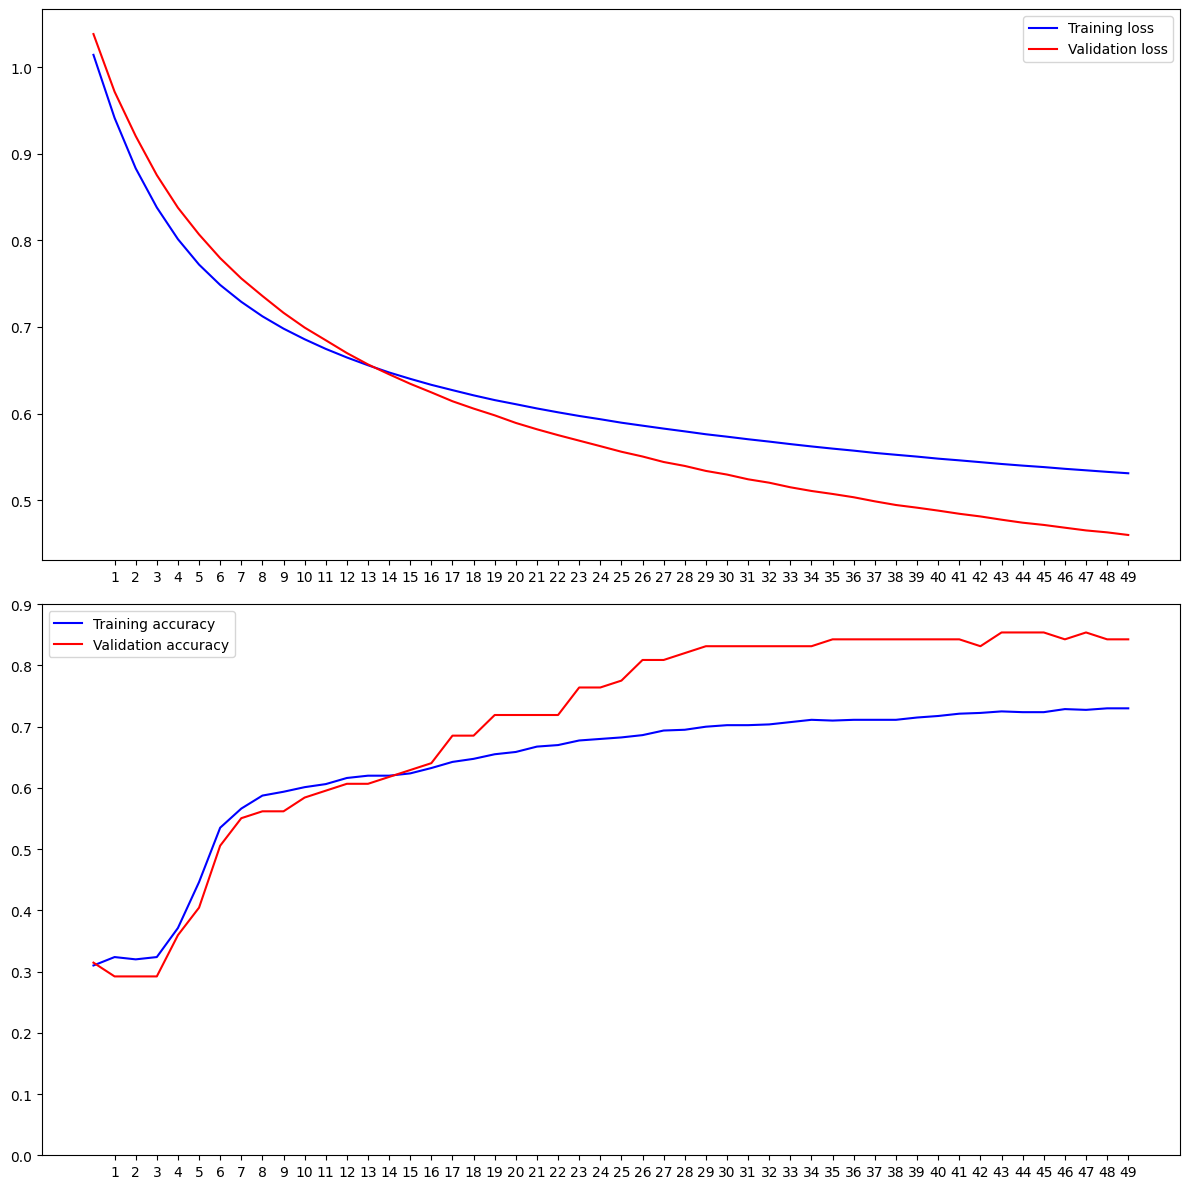

In [288]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(train.history['loss'], color='b', label="Training loss")
ax1.plot(train.history['val_loss'], color='r', label="Validation loss")
ax1.legend()
ax1.set_xticks(np.arange(1, epochs, 1))

ax2.plot(train.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(train.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.legend()
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.set_yticks(np.arange(0, 1, 0.1))

plt.tight_layout()
plt.show()

Test the model against validation data

In [289]:
(model.predict(X_test) > 0.5).astype("int32")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


array([[0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
    

In [290]:
from sklearn.metrics import classification_report

Y_train_predicted = (model.predict(X_train) > 0.5).astype("int32")
print(classification_report(Y_train, Y_train_predicted, labels=[1], target_names=["Survivor"]))

Y_test_predicted = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(Y_test, Y_test_predicted, labels=[1], target_names=["Survivor"]))

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
              precision    recall  f1-score   support

    Survivor       0.81      0.38      0.52       304

   micro avg       0.81      0.38      0.52       304
   macro avg       0.81      0.38      0.52       304
weighted avg       0.81      0.38      0.52       304

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
              precision    recall  f1-score   support

    Survivor       0.89      0.69      0.78        36

   micro avg       0.89      0.69      0.78        36
   macro avg       0.89      0.69      0.78        36
weighted avg       0.89      0.69      0.78        36



In [291]:
Y_test[0:15]

array([0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1])

In [292]:
(model.predict(X_test[0:10]) > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


array([[0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])